In [1]:
# import sys
# import turbo_seti
import glob
import os
import matplotlib
import matplotlib.pyplot as plt
# from turbo_seti.find_event.plot_dat import make_plot
from blimpy import Waterfall
import numpy as np
import pandas as pd
import blimpy as bl
from blimpy.utils import rebin
# from turbo_seti import find_event
# from turbo_seti.find_event import plot_event
import gc
from astropy.time import Time
from turbo_seti.find_event.plot_event import plot_waterfall
from turbo_seti.find_event.plot_event import overlay_drift

In [2]:
def get_source_name(fil):
    return fil.split("guppi_")[1][12:].split("_")[0]

def get_target_name(fil):
    wf = Waterfall(fil,load_data=False)
    name = wf.header['source_name']
    del wf
    gc.collect()
    return name

In [3]:
fontsize=16
font = {'family' : 'DejaVu Sans',
'size' : fontsize}
MAX_IMSHOW_POINTS = (4096, 1268)

def one_wf_plot(fil_file_list,f_start=0,f_stop=0,drift_rate=0,source_name_list=[],save_dir=None,extension='png'):

    # prepare for plotting
    matplotlib.rc('font', **font)

    # set up the sub-plots
    n_plots = len(fil_file_list)
    fig = plt.subplots(n_plots, sharex=True, sharey=True,figsize=(10, 2*n_plots))

    # read in data for the first panel
    max_load = bl.calcload.calc_max_load(fil_file_list[0])
    if not f_start:
        wf=Waterfall(fil_file_list[0],load_data=False)
        f_start=wf.container.f_start
        del wf
        gc.collect()
    if not f_stop:
        wf=Waterfall(fil_file_list[0],load_data=False)
        f_stop=wf.container.f_stop
        del wf
        gc.collect()
    wf1 = bl.Waterfall(fil_file_list[0], f_start=f_start, f_stop=f_stop, max_load=max_load)
    t0 = wf1.header['tstart']
    plot_f1, plot_data1 = wf1.grab_data()

    # rebin data to plot correctly with fewer points
    dec_fac_x, dec_fac_y = 1, 1
    if plot_data1.shape[0] > MAX_IMSHOW_POINTS[0]:
        dec_fac_x = plot_data1.shape[0] / MAX_IMSHOW_POINTS[0]
    if plot_data1.shape[1] > MAX_IMSHOW_POINTS[1]:
        dec_fac_y =  int(np.ceil(plot_data1.shape[1] /  MAX_IMSHOW_POINTS[1]))
    plot_data1 = rebin(plot_data1, dec_fac_x, dec_fac_y)

    # define more plot parameters
    mid_f = np.abs(f_start+f_stop)/2.

    subplots = []
    del wf1, plot_f1, plot_data1
    gc.collect()

    if not source_name_list:
        source_name_list=[get_source_name(f) for f in fil_file_list]

    on_source_name=get_source_name(fil_file_list[0])

    # Fill in each subplot for the full plot
    for ii, filename in enumerate(fil_file_list):
        # identify panel
        subplot = plt.subplot(n_plots, 1, ii + 1)
        subplots.append(subplot)

        # read in data
        max_load = bl.calcload.calc_max_load(filename)
        wf = bl.Waterfall(filename, f_start=f_start, f_stop=f_stop, max_load=max_load)

        # make plot with plot_waterfall
        source_name = source_name_list[ii]
        this_plot = plot_waterfall(wf,
                                    source_name,
                                    f_start=f_start,
                                    f_stop=f_stop,
                                    )

        f_mid = (f_start+f_stop)/2
        if drift_rate:
            # calculate parameters for estimated drift line
            t_elapsed = Time(wf.header['tstart'], format='mjd').unix - Time(t0, format='mjd').unix
            t_duration = (wf.n_ints_in_file - 1) * wf.header['tsamp']
            f_event = f_mid + drift_rate / 1e6 * t_elapsed

            # plot estimated drift line
            overlay_drift(f_event, f_start, f_stop, drift_rate, t_duration, offset=0)

        # Title the full plot
        if ii == 0:
            if drift_rate:
                plot_title = "%s \n $\\dot{\\nu}$ = %2.3f Hz/s, MJD:%5.5f" % (on_source_name, drift_rate, t0)
                plt.title(plot_title)
            else:
                plot_title = "%s \n MJD:%5.5f" % (on_source_name, t0)
                plt.title(plot_title)
        # Format full plot
        if ii < len(fil_file_list)-1:
            plt.xticks(np.linspace(f_start, f_stop, num=4), ['','','',''])

        del wf
        gc.collect()

    # More overall plot formatting, axis labelling
    factor = 1e6
    units = 'Hz'

    xloc = np.linspace(f_start, f_stop, 5)
    xticks = [round(loc_freq) for loc_freq in (xloc - mid_f)*factor]
    if np.max(xticks) > 1000:
        xticks = [xt/1000 for xt in xticks]
        units = 'kHz'
    plt.xticks(xloc, xticks)
    plt.xlabel("Relative Frequency [%s] from %f MHz"%(units,mid_f),fontdict=font)

    # Add colorbar
    cax = fig[0].add_axes([0.94, 0.11, 0.03, 0.77])
    fig[0].colorbar(this_plot,cax=cax,label='Normalized Power (Arbitrary Units)')

    # Adjust plots
    plt.subplots_adjust(hspace=0,wspace=0)

    # save the figures
    if save_dir:
        if save_dir[-1] != "/":
            save_dir += "/"
        path_png = save_dir + on_source_name + '_dr_' + "{:0.2f}".format(drift_rate) + '_freq_' "{:0.6f}".format(f_mid) + '.' + extension
        plt.savefig(path_png, bbox_inches='tight',format=extension)

    plt.show()

In [4]:
os.getcwd()

'/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/plots_ON_L_f3_snr10.0_old'

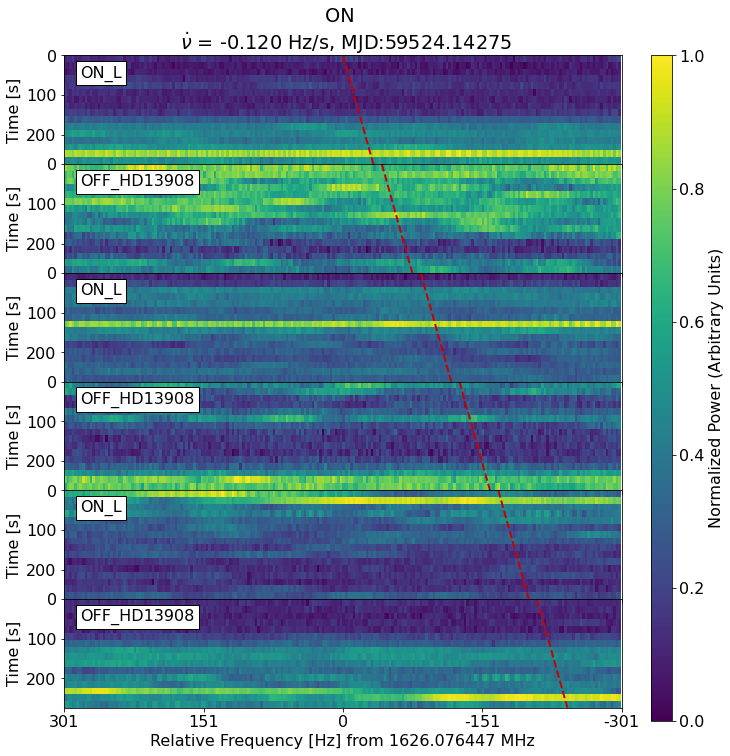

In [5]:
f_mid = 1626.076447
f_start=f_mid-0.000301
f_stop =f_mid+0.000301
drift_rate=-0.12

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

source_name_list=[get_target_name(f) for f in fils]
save_dir=None
save_dir='/gpfs/group/jtw13/default/gbt_2020/2021/plots/'

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=drift_rate,source_name_list=source_name_list,save_dir=save_dir,extension='pdf')

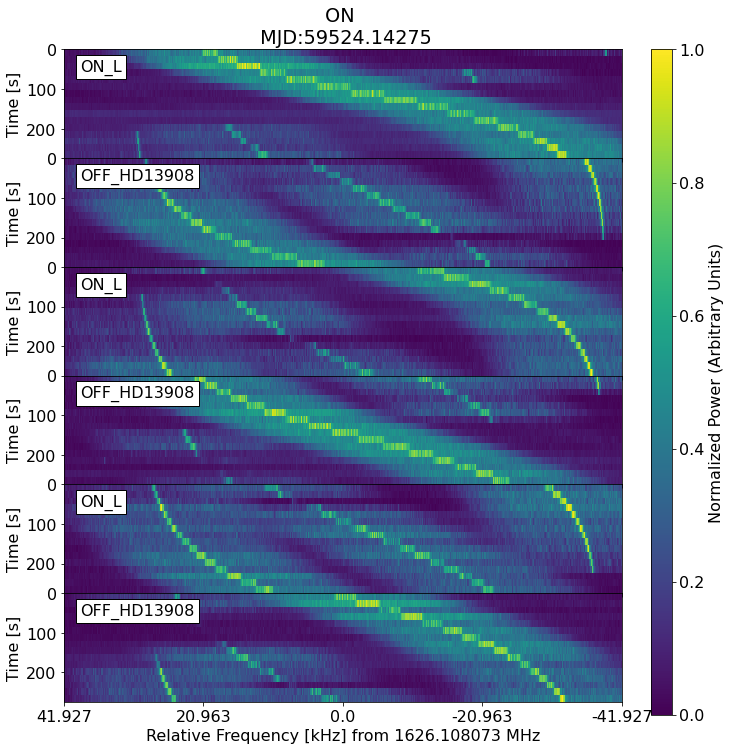

In [6]:
f_mid = 1626.108073
f_start=f_mid-0.041927
f_stop =f_mid+0.041927

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

source_name_list=[get_target_name(f) for f in fils]
save_dir=None
save_dir='/gpfs/group/jtw13/default/gbt_2020/2021/plots/'

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,source_name_list=source_name_list,save_dir=save_dir,extension='pdf')

In [12]:
wf=Waterfall(fils[0],f_start=f_start,f_stop=f_stop)
plot_f,plot_data=wf.grab_data(f_start=f_start,f_stop=f_stop)

In [13]:
np.shape(plot_data),(f_start-f_stop)/np.shape(plot_data)[1]

((16, 215), -2.8000000003335432e-06)

In [9]:
f_mid = 1626.108073
f_start=f_mid-0.000301
f_stop =f_mid+0.000301

wf=Waterfall(fils[0],f_start=f_start,f_stop=f_stop)
plot_f,plot_data=wf.grab_data(f_start=f_start,f_stop=f_stop)

In [11]:
np.shape(plot_data),(f_start-f_stop)/np.shape(plot_data)[1]

((16, 215), -2.8000000003335432e-06)

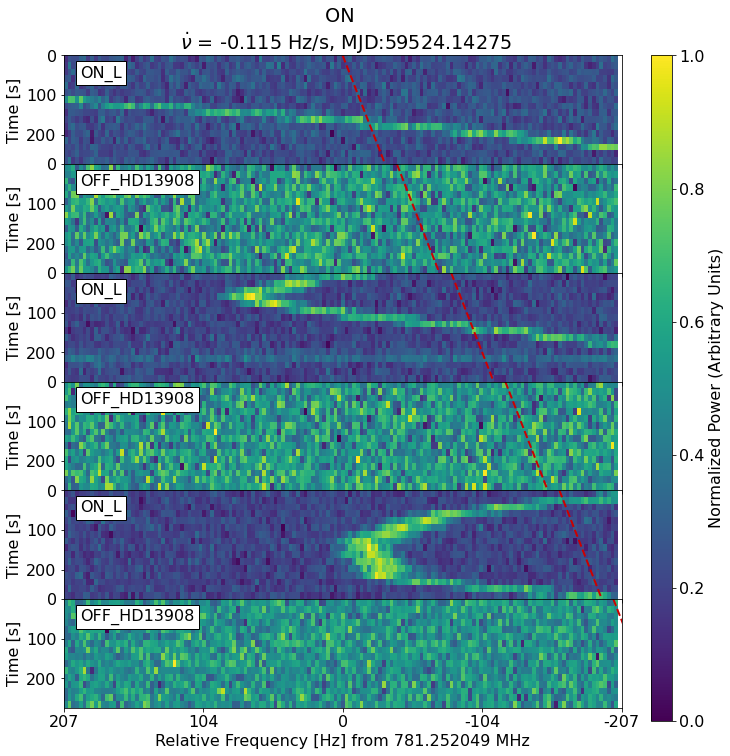

In [6]:
f_mid = 781.252049
f_start=f_mid-0.000207
f_stop =f_mid+0.000207
drift_rate=-0.115

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

source_name_list=[get_target_name(f) for f in fils]
save_dir=None
save_dir='/gpfs/group/jtw13/default/gbt_2020/2021/plots/'

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=drift_rate,source_name_list=source_name_list,save_dir=save_dir,extension='pdf')

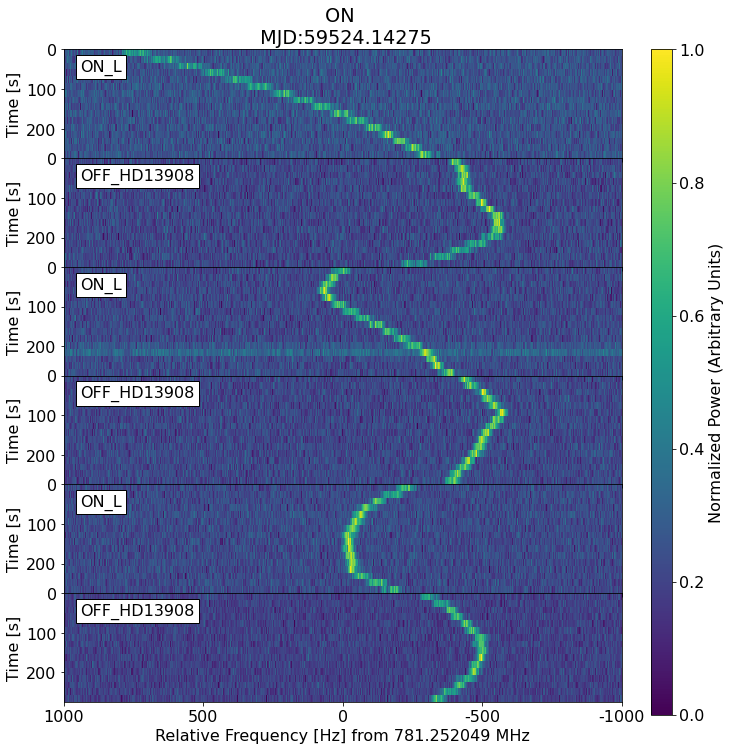

In [7]:
f_mid = 781.252049
f_start=f_mid-0.001
f_stop =f_mid+0.001
drift_rate=-0.115

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

source_name_list=[get_target_name(f) for f in fils]
save_dir=None
save_dir='/gpfs/group/jtw13/default/gbt_2020/2021/plots/'

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,source_name_list=source_name_list,save_dir=save_dir,extension='pdf')

In [ ]:
f_mid = 3963.560492
f_start=f_mid-0.0005
f_stop =f_mid+0.005

%matplotlib inline
os.chdir('/storage/home/nxt5197/scratch/PPO/TOI-216/node_by_node/blc32/Freqs_3904_to_4032/MJDate_59221/')
fils=sorted(glob.glob('*h5'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
f_mid=2273.275
f_start=f_mid-0.275
f_stop =f_mid+0.275

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/S_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
f_mid=2247.494968
f_start=f_mid-0.08
f_stop =f_mid+0.08

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/S_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
f_mid=1574.561974+0.000112
f_start=f_mid-0.001
f_stop =f_mid+0.001

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=-0.12)

In [ ]:
f_mid=1574.605730
f_start=f_mid-0.0005
f_stop =f_mid+0.0005

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=-0.12)

In [ ]:
f_mid=1381.0
f_start=f_mid-0.002
f_stop =f_mid+0.002

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*h5'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
f_mid=1621.1
f_start=f_mid-0.5
f_stop =f_mid+0.5

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/OFF_scan/')
fils=sorted(glob.glob('*h5'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
f_mid=781.252049
f_start=f_mid-0.001
f_stop =f_mid+0.001

%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*fil'))

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
# dats=sorted(glob.glob('blc03*.dat'))
fils=sorted(glob.glob('blc03*.fil'))
fils

In [ ]:
for fil in fils:
    print(fil.split("guppi_")[1][12:].split("_")[0])

In [ ]:
# dat=dats[0]
fil=fils[0]
f_start=1626.076146
f_stop=1626.076747
t0=59524.14275
source_name='ON'
wf=Waterfall(fil,load_data=False)
wf.info()

In [ ]:
%matplotlib inline
all_data=[]
extent_list=[]
f_start=1625.076146
f_stop=1627.076747
for fil in fils:
    source_name=fil.split("guppi_")[1][12:].split("_")[0]
    # fig,ax = plt.subplots(figsize=(15,8))
    wf=Waterfall(fil,max_load=8.0)
    plot_f, plot_data = wf.grab_data(f_start=f_start, f_stop=f_stop)
    timestamps=wf.timestamps
    dec_fac_x, dec_fac_y = 1, 1

    # rebinning data to plot correctly with fewer points
    try:
        if plot_data.shape[0] > MAX_IMSHOW_POINTS[0]:
            dec_fac_x = plot_data.shape[0] / MAX_IMSHOW_POINTS[0]
        if plot_data.shape[1] > MAX_IMSHOW_POINTS[1]:
            dec_fac_y =  int(np.ceil(plot_data.shape[1] /  MAX_IMSHOW_POINTS[1]))
        plot_data = rebin(plot_data, dec_fac_x, dec_fac_y)
    except Exception as ex:
        print('\n*** Oops, grab_data returned plot_data.shape={}, plot_f.shape={}'
                .format(plot_data.shape, plot_f.shape))
        print('Waterfall info for {}:'.format(wf.filename))
        wf.info()
        raise ValueError('*** Something is wrong with the grab_data output!') from ex
    del wf
    gc.collect()

    # Rolled back PR #82

    # determine extent of the plotting panel for imshow
    extent=(plot_f[0], plot_f[-1], (timestamps[-1]-timestamps[0])*24.*60.*60, 0.0)
    extent_list.append(extent)

    # plot and scale intensity (log vs. linear)
    # kwargs['cmap'] = kwargs.get('cmap', 'viridis')
    plot_data = 10.0 * np.log10(plot_data)

    # get normalization parameters
    vmin = plot_data.min()
    vmax = plot_data.max()
    normalized_plot_data = (plot_data - vmin) / (vmax - vmin)
    all_data.append(normalized_plot_data)

    # display the waterfall plot
    this_plot = plt.imshow(normalized_plot_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
    )

    # add plot labels
    plt.xlabel("Frequency [Hz]",fontdict=font)
    plt.ylabel("Time [s]",fontdict=font)

    # add source name
    ax = plt.gca()
    plt.text(0.03, 0.8, source_name, transform=ax.transAxes, bbox=dict(facecolor='white'))
    plt.show()

In [ ]:
fixed_extent=[extent[0],extent[1],extent[2]*6,extent[3]]

In [ ]:
fixed_data=np.array(all_data).reshape(np.array(all_data).shape[0]*np.array(all_data).shape[1],np.array(all_data).shape[2])
# fig,ax = plt.subplots(figsize=(15,8))
# plt.imshow(fixed_data,
#         aspect='auto',
#         rasterized=True,
#         interpolation='nearest',
#         extent=fixed_extent,
#     )
# plt.show()

In [ ]:
plt.imshow(fixed_data,
        aspect='auto',
        rasterized=True,
        interpolation='nearest',
        extent=extent,
    )
    

In [ ]:
csvs=sorted(glob.glob('./splice_no_overlap_ordered/*.csv'))
f3_hits=pd.read_csv(csvs[2])
f3_hits

In [ ]:
wf=Waterfall(fil,load_data=False)
wf.container.f_start,wf.container.f_stop

In [ ]:
%matplotlib inline

fils=sorted(glob.glob('blc03*fil'))
fil_file_list=fils
csvs=sorted(glob.glob('./splice_no_overlap_ordered/*.csv'))
f3_hits=pd.read_csv(csvs[2])
hit=f3_hits.iloc[2]
f_start=hit.FreqEnd
f_stop=hit.FreqStart
drift_rate=hit.DriftRate
on_source_name=hit.Hit_ID

# f_start=1625.076146
# f_stop=1627.076747

source_name_list=[get_source_name(f) for f in fils]

num_nodes=1

for n in range(num_nodes):
    fils=sorted(glob.glob(f'blc0{n}*fil'))
    wf=Waterfall(fils[0],load_data=False)
    f_start=wf.container.f_start
    f_stop=wf.container.f_stop
    frange=f_stop-f_start
    for i in range(10):
        # one_wf_plot(fils,f_start=f_start,f_stop=f_start+frange/10)
        f_start+=frange/10

In [ ]:
os.getcwd()

In [ ]:
%matplotlib inline

os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/')
fils=sorted(glob.glob('blc03*fil'))
fil_file_list=fils
# csvs=sorted(glob.glob('./splice_no_overlap_ordered/*.csv'))
# f3_hits=pd.read_csv(csvs[2])
# hit=f3_hits.iloc[2]
# f_start=hit.FreqEnd
# f_stop=hit.FreqStart
# drift_rate=hit.DriftRate
# on_source_name=hit.Hit_ID

# f_start=1625.076146
# f_stop=1627.076747

source_name_list=[get_source_name(f) for f in fils]

num_nodes=1
segs=100

for n in range(num_nodes):
    fils=sorted(glob.glob(f'blc0{n}*fil'))
    wf=Waterfall(fils[0],load_data=False)
    f_start=wf.container.f_start
    f_stop=wf.container.f_stop
    frange=f_stop-f_start
    for i in range(segs):
        # one_wf_plot(fils,f_start=f_stop-frange/segs,f_stop=f_stop)
        f_stop-=frange/segs

In [ ]:
%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/L_band/splice_no_overlap_ordered/')
fils=sorted(glob.glob('*fil'))

f_start=1626.076146-0.02
f_stop =1626.076146+0.08
# f_start=1626.06
# f_stop=1626.15

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/S_band/splice_no_overlap_ordered')
fils=sorted(glob.glob('*0.h5'))

f_start = 2465.993508-0.02
f_stop = 2465.993508+0.02

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/S_band/splice_no_overlap_ordered')
fils=sorted(glob.glob('*0.h5'))

f_start = 2463.057160-0.02
f_stop = 2463.057160+0.02

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
%matplotlib inline
os.chdir('/gpfs/group/jtw13/default/gbt_2020/2021/S_band/splice_no_overlap_ordered')
fils=sorted(glob.glob('*0.h5'))

f_start = 2463.057160-0.02
f_stop = 2465.993508+0.02

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
%matplotlib inline
os.chdir('/storage/home/nxt5197/scratch/Unspliced/day_1_57688/day_1_57688/node_by_node/blc00/Freqs_10813_to_11001/')
fils=sorted(glob.glob('*0.h5'))

f_start = 2463.057160-0.02
f_stop = 2465.993508+0.02
f_start = 10993.986673
f_stop = 10993.986673+1
drift_rate=-1941.595581
drift_rate=0

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=drift_rate)


In [ ]:
%matplotlib inline
os.chdir('/storage/home/nxt5197/scratch/PPO/TRAPPIST-1/node_by_node/blc01/Freqs_11701_to_11888/')
fils=sorted(glob.glob('*0.h5'))

f_start = 11871.379070-0.014862
f_stop = 11871.379070+0.014862
f_start = 11871.379070-0.5
f_stop = 11871.379070+0.5
drift_rate=0

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=drift_rate)


In [ ]:
%matplotlib inline
os.chdir('/storage/home/nxt5197/scratch/PPO/TOI-216/unspliced/blc04/Freqs_1216_to_1344/')
fils=sorted(glob.glob('*0.h5'))

f_start = 1342.973336-0.02
f_stop = 1342.992688+0.02

# source_name_list=[get_source_name(f) for f in fils]

one_wf_plot(fils,f_start=f_start,f_stop=f_stop)#,drift_rate=-0.12)

In [ ]:
%matplotlib inline
folder=f'/storage/home/nxt5197/scratch/Unspliced/day_2_57741-2/day_2_57741-2/node_by_node/kpfa_combined/Freqs_20513_to_20701/'
os.chdir(folder)
fils=sorted(glob.glob('*0.h5'))

for f in fils:
    print(f)
f_stop = 20695.605467
f_start = 20693.868667
f_start= 20694.162067-0.025
f_stop = 20694.162067-0.0125
f_start= 20694.143317-0.003125
f_stop = 20694.143317-0.002

# # source_name_list=[get_source_name(f) for f in fils]
drift_rate=0
# drift_rate=962.8

one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=drift_rate)

In [ ]:
X=[3625.006598,3687.4515085000003,3749.937499,3749.9380325,3750.01069,3750.019569,3750.0521074999997,3761.7188475000003,3764.648474,3791.015703,
3793.9454244999997,3799.804763,3811.5235045,3820.3125645,3823.242257,3840.8203515,3840.8203795,3840.8204045,3846.6797935,3858.3984655,
3864.257843,3870.117249,3873.046906,3878.9063450000003,3893.5547795,3896.484411,3902.3437835,3905.2734765,3914.062573,3916.9922905000003,
3925.781281,3925.7813255,3937.504339,3966.7969865,4028.3204299999998,4040.0391745,4693.359425000001,4702.148488000001,5821.289096,
6943.359464499999,8312.4653815,8317.382927499999,8329.1016965,8334.960951500001,8343.750114499999,8358.3985465,8367.1876315,8393.5548215,
8437.387906,8437.687931,8437.9751445,8437.975187,8437.987955]
folder=f'/gpfs/group/jtw13/default/gbt_2020/2021/C_band/splice_no_overlap_ordered/'
os.chdir(folder)
fils=sorted(glob.glob('*0.h5'))
for freq in X:
    print(f'Frequency: {freq}')
    f_start=freq-0.02
    f_stop=freq+0.02
    drift_rate=0
    one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=drift_rate)
    

In [ ]:
f_starts=[8437.9743432356,
3870.116560212,
3840.8196390538,
3820.3117723938,
3811.522695175,
3799.803902015,
3750.0514187119998,
8437.974300735601,
8312.4645893938,
3749.9372403938,
3687.4507163938,
6943.358741272599,
5821.2882522356,
4040.0383651750003,
4028.3195862355997,
3966.7961943938,
3937.5036329932,
8334.960211053802,
3925.7805577726,
3905.272667175,
3902.3429913938,
3896.4835500149998,
3873.046217212,
3864.2571197725997,
3858.397776712,
3840.8195593938,
3764.6477335538,
3750.0188113332,
8437.9872489932,
8437.6872077726,
8437.3871999932,
4702.147781993201,
4693.3587189932005,
3925.7805161750002,
3914.0617808938,
3823.2415165538,
3791.0149108938,
3750.009829015,
3749.9367929932,
3625.0058058938,
8393.5539777356,
8367.186770515002,
8358.3978404932,
8343.749408493199,
8329.1008527356,
8317.3821870538,
3916.9914467356,
3893.5540390538004,
3878.9056217726,
3846.678984175,
3840.8196984932,
3793.9445635149996,
3761.7180898332003]
f_stops=[8437.9760307644,
3870.117937788,
3840.8211199462,
3820.3133566062,
3811.524313825,
3799.8056239850002,
3750.0527962879996,
8437.9759882644,
8312.4661736062,
3749.9388246062003,
3687.4523006062004,
6943.3601877273995,
5821.2899397644005,
4040.039983825,
4028.3212737644,
3966.7977786062,
3937.5050450068,
8334.9616919462,
3925.7820042274,
3905.274285825,
3902.3445756062,
3896.485271985,
3873.047594788,
3864.2585662274,
3858.399154288,
3840.8211436062,
3764.6492144462,
3750.0203266668,
8437.9886610068,
8437.6886542274,
8437.3886120068,
4702.149194006801,
4693.360131006801,
3925.782134825,
3914.0633651062003,
3823.2429974461998,
3791.0164951062,
3750.011550985,
3749.9382050068,
3625.0073901062,
8393.555665264399,
8367.188492485,
8358.3992525068,
8343.750820506799,
8329.102540264399,
8317.383667946198,
3916.9931342644004,
3893.5555199462,
3878.9070682274005,
3846.680602825,
3840.8211105068003,
3793.946285485,
3761.7196051668]
folder=f'/gpfs/group/jtw13/default/gbt_2020/2021/C_band/splice_no_overlap_ordered/'
os.chdir(folder)
fils=sorted(glob.glob('*0.h5'))
for x in range(1):
    print(f'Frequency Range: {f_starts[x]} to {f_stops[x]}')
    f_start=f_starts[x]
    f_stop=f_stops[x]
    drift_rate=0
    one_wf_plot(fils,f_start=f_start,f_stop=f_stop,drift_rate=drift_rate)
    plt.show()